# k-Nearest-Neighbor classification for handwritten digits

In this notebook I will build a classifier that takes an image of a handwritten digit and outputs a label 0-9. deploy a particularly simple strategy for this problem known as the **nearest neighbor classifier**.

To run this notebook I have the following Python packages installed:
* `numpy`
* `matplotlib`
* `sklearn`

## 1. The MNIST dataset

`MNIST` is a classic dataset in machine learning, consisting of 28x28 gray-scale images handwritten digits. The original training set contains 60,000 examples and the test set contains 10,000 examples. In this notebook I will be working with a subset of this data: a training set of 7,500 examples and a test set of 1,000 examples.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import time

## Load the training set
train_data = np.load('MNIST/train_data.npy')
train_labels = np.load('MNIST/train_labels.npy')

## Load the testing set
test_data = np.load('MNIST/test_data.npy')
test_labels = np.load('MNIST/test_labels.npy')

In [2]:
## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data))
print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

Training dataset dimensions:  (7500, 784)
Number of training labels:  7500
Testing dataset dimensions:  (1000, 784)
Number of testing labels:  1000


In [3]:
## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))

Training set distribution:
{0: 750, 1: 750, 2: 750, 3: 750, 4: 750, 5: 750, 6: 750, 7: 750, 8: 750, 9: 750}
Test set distribution:
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100}


## 2. Visualizing the data
Each data point is stored as 784-dimensional vector. To visualize a data point, let's first reshape it to a 28x28 image.

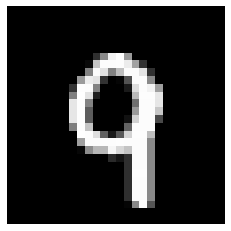

Label 9


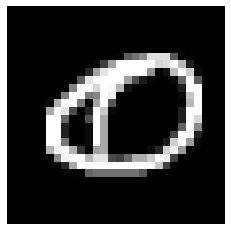

Label 0


In [4]:
## Define a function that displays a digit given its vector representation
def show_digit(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    if(dataset=="train"): 
        show_digit(train_data[index,])
        label = train_labels[index]
    else:
        show_digit(test_data[index,])
        label = test_labels[index]
    print("Label " + str(label))
    return

## View the first data point in the training set
vis_image(0, "train")

## Now view the first data point in the test set
vis_image(0, "test")

## 3. Squared Euclidean distance

In order to compute the nearest neighbor in the data set for a given image, the distance of the given image to every image in the data set is calculated. There a different distance functions which can be applied, here I will use the squared *Euclidean distance*: 
$$\|x - y\|^2 = {\sum_{i=1}^d (x_i - y_i)^2}.$$

The following function computes the squared Euclidean distance:

In [6]:
## Computes squared Euclidean distance between two vectors.
def squared_dist(x,y):
    return np.sum(np.square(x-y))

# To get a feeling for the distance function, let's compute some distances: 
# Compute the distance between a seven and a one in the training set.
print("Distance from 7 to 1: ", squared_dist(train_data[4,],train_data[5,]))

## Compute the distance between a seven and a two in the training set.
print("Distance from 7 to 2: ", squared_dist(train_data[4,],train_data[1,]))

## Compute the distance between two seven's in the training set.
print("Distance from 7 to 7: ", squared_dist(train_data[4,],train_data[7,]))

Distance from 7 to 1:  5357193.0
Distance from 7 to 2:  12451684.0
Distance from 7 to 7:  5223403.0


## 4. Computing nearest neighbors

Now that a distance function is defined, let's turn to nearest neighbor classification. 

In [7]:
## Takes a vector x and returns the index of its nearest neighbor in train_data
def find_NN(x):
    # Compute distances from x to every row in train_data
    distances = [squared_dist(x,train_data[i,]) for i in range(len(train_labels))]
    # Get the index of the smallest distance
    return np.argmin(distances)

## Takes a vector x and returns the class of its nearest neighbor in train_data
def NN_classifier(x):
    # Get the index of the the nearest neighbor
    index = find_NN(x)
    # Return its class
    return train_labels[index]

A success case:
NN classification:  0
True label:  0
The test image:


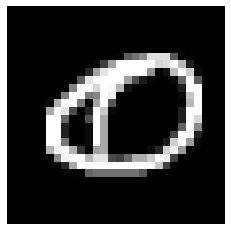

Label 0
The corresponding nearest neighbor image:


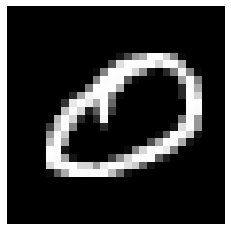

Label 0


In [8]:
## A success case:
print("A success case:")
print("NN classification: ", NN_classifier(test_data[0,]))
print("True label: ", test_labels[0])
print("The test image:")
vis_image(0, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_NN(test_data[0,]), "train")

A failure case:
NN classification:  2
True label:  3
The test image:


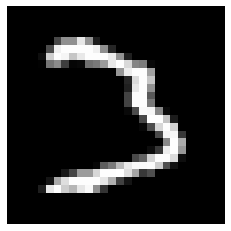

Label 3
The corresponding nearest neighbor image:


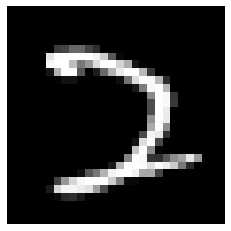

Label 2


In [9]:
## A failure case:
print("A failure case:")
print("NN classification: ", NN_classifier(test_data[39,]))
print("True label: ", test_labels[39])
print("The test image:")
vis_image(39, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_NN(test_data[39,]), "train")

## 5. Processing the full test set

Now let's apply the nearest neighbor classifier over the full data set. 


In [10]:
## Predict on each test data point (and time it!)
t_before = time.time()
test_predictions = [NN_classifier(test_data[i,]) for i in range(len(test_labels))]
t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier: ", error)
print("Classification time (seconds): ", t_after - t_before)

Error of nearest neighbor classifier:  0.046
Classification time (seconds):  107.81286311149597


## 6. Faster nearest neighbor methods

Performing nearest neighbor classification in the way it's presented above requires a full pass through the training set in order to classify a single point. If there are $N$ training points in $\mathbb{R}^d$, this takes $O(N d)$ time.

Fortunately, there are faster methods to perform nearest neighbor look up if we are willing to spend some time preprocessing the training set. `scikit-learn` has fast implementations of two useful nearest neighbor data structures: the _ball tree_ and the _k-d tree_. 

These two algorithms are faster because the models are just calculated once and it's not neccessary to calculate the distance to every image in the data set for the classification of a new image.

In [13]:
from sklearn.neighbors import BallTree

## Build nearest neighbor structure on training data
t_before = time.time()
ball_tree = BallTree(train_data)
t_after = time.time()

## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(ball_tree.query(test_data, k=1, return_distance=False))
ball_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)

## Verify that the predictions are the same
print("Ball tree produces same predictions as above? ", np.array_equal(test_predictions, ball_tree_predictions))

Time to build data structure (seconds):  1.3515431880950928
Time to classify test set (seconds):  7.508858680725098
Ball tree produces same predictions as above?  True


In [14]:
from sklearn.neighbors import KDTree

## Build nearest neighbor structure on training data
t_before = time.time()
kd_tree = KDTree(train_data)
t_after = time.time()

## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(kd_tree.query(test_data, k=1, return_distance=False))
kd_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)

## Verify that the predictions are the same
print("KD tree produces same predictions as above? ", np.array_equal(test_predictions, kd_tree_predictions))

Time to build data structure (seconds):  1.5845370292663574
Time to classify test set (seconds):  9.48619270324707
KD tree produces same predictions as above?  True
